## Imports

In [50]:
from keras import layers, callbacks, utils, metrics, Sequential, optimizers, initializers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
import keras_tuner as kt
import keras
import json
import pickle
import shutil
import pandas as pd

## Constants

In [51]:
# Constantes
IS_TO_FIND_BEST_HYPERPARAMS = False
IS_TO_TRAIN = False

BATCH_SIZE = 64
IMG_HEIGHT = 256
IMG_WIDTH = 256
LEARNING_RATE = 1e-5

DATASET_PATH = "../cats_and_dogs"
DATASET_TRAIN_PATH = f"{DATASET_PATH}/train"
DATASET_VAL_PATH = f"{DATASET_PATH}/validation"

NUM_CLASSES = 2

SEED = 7654321

VAL_TEST_RATIO = 0.5

MAX_EPOCHS = 75

BEST_MODEL_WEIGHTS = "../models/best_custom_model.weights.h5"
HYPERPARAMS_FILENAME = "../models/best_custom_model.hyperparams.json"
HISTORY_FILENAME = "../models/best_custom_model.history.pkl"
BEST_MODEL_WITH_AUGMENTATION_HISTORY_FILENAME = "../models/best_custom_model_with_augmentation.history.pkl"
BEST_MODEL_WITHOUT_AUGMENTATION_HISTORY_FILENAME = "../models/best_custom_model_without_augmentation.history.pkl"

# callback para parar o treino caso não se verifiquem melhorias na loss
EARLY_STOPPING = callbacks.EarlyStopping(monitor="val_loss", patience=5)

INITIALIZER = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=SEED)
GLOROT_UNIFORM_INITIALIZER = initializers.GlorotUniform(seed=SEED)

DEFAULT_LOSS = "binary_crossentropy"
DEFAULT_METRICS = ["accuracy"]

# Dataset load

In [52]:
train_ds = utils.image_dataset_from_directory(
    DATASET_TRAIN_PATH,
    labels="inferred",
    label_mode="binary",
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    verbose=False,
)

val_ds, test_ds = utils.image_dataset_from_directory(
    DATASET_VAL_PATH,
    labels="inferred",
    label_mode="binary",
    validation_split=VAL_TEST_RATIO,
    subset="both",
    seed=SEED,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    verbose=False,
)
LABELS = train_ds.class_names
print("Encontradas as classes: ", LABELS)

# load the datasets into memory - once loaded, the order of the batches will no longer change
train_ds = train_ds.cache()
val_ds = val_ds.cache()
test_ds = test_ds.cache()

Using 500 files for training.
Using 500 files for validation.
Encontradas as classes:  ['cats', 'dogs']


# Finding the best custom CNN architecture

In [53]:
if IS_TO_FIND_BEST_HYPERPARAMS:

    CNN_ARCHITECTURE_LEVEL_STRUCTURE = {
            1: 4,
            2: 3,
            3: 3,
            4: 2,
            5: 2,
            6: 1
        }

    def build_model(hp):
        """
        Build a CNN model with hyperparameters to tune
        
        Args:
            hp (keras_tuner.HyperParameters): Hyperparameters to optimize
        
        Returns:
            keras.Model: Compiled model with tuned hyperparameters
        """
        model = Sequential()
        
        # Input layer
        model.add(layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)))

        # Data augmentation layer
        model.add(layers.RandomRotation(hp.Float(f'random_rotation_factor', 0., 0.2, step=0.05), seed=SEED))
        model.add(layers.RandomZoom(hp.Float(f'random_zoom_factor', 0., 0.2, step=0.05), seed=SEED))
        model.add(layers.RandomSaturation(hp.Float(f'random_saturation_factor', 0.5, 0.8, step=0.05), seed=SEED))
        model.add(layers.RandomSharpness(hp.Float(f'random_sharpness_factor', 0.5, 0.8, step=0.05), seed=SEED))

        for sub_level, number_of_conv_layers in CNN_ARCHITECTURE_LEVEL_STRUCTURE.items():

            # Convolutional layers with tunable depth and filters
            for index in range(number_of_conv_layers):
                model.add(layers.Conv2D(
                    filters=32 * (sub_level + 1),
                    kernel_size=3,
                    activation='relu',
                    padding='same'
                ))

            model.add(layers.MaxPooling2D(4 if sub_level == 0 or sub_level == 1 else 2))

        # Hidden layer
        model.add(layers.Dense(128, activation="relu", kernel_initializer=INITIALIZER))
        model.add(layers.Dropout(hp.Float(f'dropout_rate', 0.0, 0.2, step=0.05), seed=SEED))
        model.add(layers.Dense(160, activation="relu", kernel_initializer=INITIALIZER))
        
        # Flatten and dense layers
        model.add(layers.Flatten())

        # Classifier
        model.add(layers.Dense(1, activation='sigmoid', kernel_initializer=INITIALIZER))
        
        # Compile model
        model.compile(
            loss=DEFAULT_LOSS,
            optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
            metrics=DEFAULT_METRICS
        )

        return model

    # Grid Search tuner
    tuner = kt.GridSearch(
        build_model,
        objective='val_accuracy',
        max_trials=1,
        # max_trials=50,
        directory='hyperparameter_tuning',
        project_name='cats_dogs_cnn',
        overwrite=True
    )

    # Early stopping callback
    stop_early = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5
    )

    # Perform hyperparameter search
    tuner.search(
        train_ds,
        validation_data=val_ds,
        epochs=MAX_EPOCHS,
        callbacks=[EARLY_STOPPING]
    )

    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

    print("Best Hyperparameters:")
    for param, value in best_hyperparameters.values.items():
        print(f"{param}: {value}")

    # Save the best hyperparameters to a JSON file
    with open(HYPERPARAMS_FILENAME, 'w') as file:
        json.dump(best_hyperparameters.values, file, indent=4)

    print(f"\nBest hyperparameters saved to {HYPERPARAMS_FILENAME}")

else:
    # Load the best hyperparameters from the JSON file
    with open(HYPERPARAMS_FILENAME, 'r') as file:
        best_hyperparameters = json.load(file)

    print(f"Loaded hyperparameters from {HYPERPARAMS_FILENAME}:")
    for param, value in best_hyperparameters.items():
        print(f"{param}: {value}")

Loaded hyperparameters from ../models/best_custom_model.hyperparams.json:
random_rotation_factor: 0.0
random_zoom_factor: 0.0
random_saturation_factor: 0.5
random_sharpness_factor: 0.7
dropout_rate: 0.1


# Compare CNN with and without data augmentation

## CNN without data augmentation

In [54]:
if IS_TO_TRAIN:
    cnn_without_augmentation = Sequential(
        [
            layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

            # Low level features
            layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.MaxPooling2D(pool_size=(4, 4)),

            layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.MaxPooling2D(pool_size=(4, 4)),

            # Mid level features
            layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.MaxPooling2D(),

            layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.MaxPooling2D(),

            # High level features
            layers.Conv2D(96, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.Conv2D(96, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.MaxPooling2D(),

            layers.Conv2D(96, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.MaxPooling2D(),

            # Hidden layer
            layers.Dense(128, activation="relu", kernel_initializer=INITIALIZER),
            layers.Dense(160, activation="relu", kernel_initializer=INITIALIZER),

            # Classifier
            layers.Flatten(),
            layers.Dense(1, activation="sigmoid", kernel_initializer=INITIALIZER)
        ], name="cnn_without_augmentation"
    )

    cnn_without_augmentation.compile(
        loss=DEFAULT_LOSS,
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
        metrics=DEFAULT_METRICS
    )

    best_model_checkpoint = callbacks.ModelCheckpoint(
        filepath=f"../models/best_custom_model_without_augmentation.weights.h5",
        save_weights_only=True,
        monitor="val_loss",
        mode="min",
        save_best_only=True,
    )

    cnn_without_augmentation_history = cnn_without_augmentation.fit(
        train_ds,
        validation_data=val_ds,
        epochs=MAX_EPOCHS,
        callbacks=[best_model_checkpoint, EARLY_STOPPING]
    )

    with open(BEST_MODEL_WITHOUT_AUGMENTATION_HISTORY_FILENAME, "wb") as file:
            pickle.dump(cnn_without_augmentation_history, file)

else:
    with open(BEST_MODEL_WITHOUT_AUGMENTATION_HISTORY_FILENAME, "rb") as file:
        cnn_without_augmentation_history = pickle.load(file)

## CNN with augmentation

In [55]:
if IS_TO_TRAIN:
    cnn_with_augmentation = Sequential(
        [
            layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

            # Data augmentation
            layers.RandomSharpness(best_hyperparameters["random_sharpness_factor"], seed=SEED),

            # Low level features
            layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.MaxPooling2D(pool_size=(4, 4)),

            layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.MaxPooling2D(pool_size=(4, 4)),

            # Mid level features
            layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.MaxPooling2D(),

            layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.MaxPooling2D(),

            # High level features
            layers.Conv2D(96, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.Conv2D(96, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.MaxPooling2D(),

            layers.Conv2D(96, 3, padding="same", activation="relu", kernel_initializer=GLOROT_UNIFORM_INITIALIZER),
            layers.MaxPooling2D(),

            # Hidden layer
            layers.Dense(128, activation="relu", kernel_initializer=INITIALIZER),

            # Dropout layer
            layers.Dropout(best_hyperparameters["dropout_rate"]),

            layers.Dense(160, activation="relu", kernel_initializer=INITIALIZER),

            # Classifier
            layers.Flatten(),
            layers.Dense(1, activation="sigmoid", kernel_initializer=INITIALIZER)
        ], name="cnn_with_augmentation"
    )

    cnn_with_augmentation.compile(
        loss=DEFAULT_LOSS,
        optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
        metrics=DEFAULT_METRICS
    )

    best_model_checkpoint = callbacks.ModelCheckpoint(
        filepath=f"../models/best_custom_model_with_augmentation.weights.h5",
        save_weights_only=True,
        monitor="val_loss",
        mode="min",
        save_best_only=True,
    )

    cnn_with_augmentation_history = cnn_without_augmentation.fit(
        train_ds,
        validation_data=val_ds,
        epochs=MAX_EPOCHS,
        callbacks=[best_model_checkpoint, EARLY_STOPPING]
    )

    with open(BEST_MODEL_WITH_AUGMENTATION_HISTORY_FILENAME, "wb") as file:
            pickle.dump(cnn_with_augmentation_history, file)

else:
    with open(BEST_MODEL_WITH_AUGMENTATION_HISTORY_FILENAME, "rb") as file:
        cnn_with_augmentation_history = pickle.load(file)

## Compare both models

/Users/xoutoz/workspace/master/APVC/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


,Metric,Without Augmentation,With Augmentation
0,Precision,0.6996,0.6996
1,Recall,0.7108,0.7108
2,F1 Score,0.7052,0.7052
3,Validation Loss,0.5720,0.5721
4,Validation Accuracy,0.7040,0.7040


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


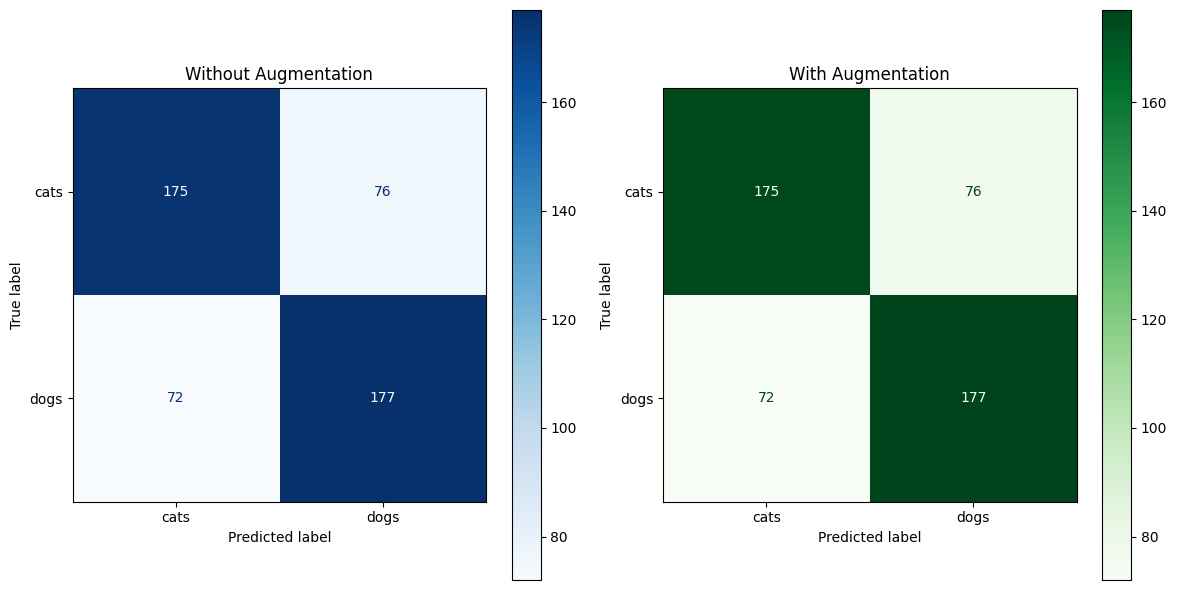

In [56]:
# Load best weights for cnn_without_augmentation model
cnn_without_augmentation.load_weights("../models/best_custom_model_without_augmentation.weights.h5")

# Load best weights for cnn_with_augmentation model
cnn_with_augmentation.load_weights("../models/best_custom_model_with_augmentation.weights.h5")

# Evaluate cnn_without_augmentation model
cnn_without_augmentation_val_loss, cnn_without_augmentation_val_accuracy = cnn_without_augmentation.evaluate(val_ds, verbose=0)

# Evaluate cnn_with_augmentation model
cnn_with_augmentation_val_loss, cnn_with_augmentation_val_accuracy = cnn_with_augmentation.evaluate(val_ds, verbose=0)

y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

# Print comparison results
# Calculate precision, recall, and F1 score for cnn_without_augmentation
precision_without_aug = precision_score(y_true, (cnn_without_augmentation.predict(val_ds) > 0.5).astype(int).flatten())
recall_without_aug = recall_score(y_true, (cnn_without_augmentation.predict(val_ds) > 0.5).astype(int).flatten())
f1_without_aug = f1_score(y_true, (cnn_without_augmentation.predict(val_ds) > 0.5).astype(int).flatten())

# Calculate precision, recall, and F1 score for cnn_with_augmentation
precision_with_aug = precision_score(y_true, (cnn_with_augmentation.predict(val_ds) > 0.5).astype(int).flatten())
recall_with_aug = recall_score(y_true, (cnn_with_augmentation.predict(val_ds) > 0.5).astype(int).flatten())
f1_with_aug = f1_score(y_true, (cnn_with_augmentation.predict(val_ds) > 0.5).astype(int).flatten())

# Create a pandas DataFrame to display the comparison results
data = {
    "Metric": ["Precision", "Recall", "F1 Score", "Validation Loss", "Validation Accuracy"],
    "Without Augmentation": [
        round(precision_without_aug, 4),
        round(recall_without_aug, 4),
        round(f1_without_aug, 4),
        round(cnn_without_augmentation_val_loss, 4),
        round(cnn_without_augmentation_val_accuracy, 4)
    ],
    "With Augmentation": [
        round(precision_with_aug, 4),
        round(recall_with_aug, 4),
        round(f1_with_aug, 4),
        round(cnn_with_augmentation_val_loss, 4),
        round(cnn_with_augmentation_val_accuracy, 4)
    ],
}

df_comparison = pd.DataFrame(data)
display(df_comparison)


# Display confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Confusion matrix for cnn_without_augmentation
ConfusionMatrixDisplay.from_predictions(
    y_true,
    (cnn_without_augmentation.predict(val_ds) > 0.5).astype(int).flatten(),
    display_labels=LABELS,
    cmap="Blues",
    ax=axes[0]
)
axes[0].set_title("Without Augmentation")

# Confusion matrix for cnn_with_augmentation
ConfusionMatrixDisplay.from_predictions(
    y_true,
    (cnn_with_augmentation.predict(val_ds) > 0.5).astype(int).flatten(),
    display_labels=LABELS,
    cmap="Greens",
    ax=axes[1]
)
axes[1].set_title("With Augmentation")

plt.tight_layout()
plt.show()

# Find the best trained model iteration

In [57]:
if IS_TO_TRAIN:
    models_array = []
    history_array = []
    for rep in range(1, 11):
        print(f"Trial {rep} running...")
        cat_or_dog_training_model = Sequential(
            [
                layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

                # Low level features
                layers.Conv2D(32, 3, padding="same", activation="relu"),
                layers.Conv2D(32, 3, padding="same", activation="relu"),
                layers.Conv2D(32, 3, padding="same", activation="relu"),
                layers.Conv2D(32, 3, padding="same", activation="relu"),
                layers.MaxPooling2D(pool_size=(4, 4)),

                layers.Conv2D(32, 3, padding="same", activation="relu"),
                layers.Conv2D(32, 3, padding="same", activation="relu"),
                layers.Conv2D(32, 3, padding="same", activation="relu"),
                layers.MaxPooling2D(pool_size=(4, 4)),

                # Mid level features
                layers.Conv2D(64, 3, padding="same", activation="relu"),
                layers.Conv2D(64, 3, padding="same", activation="relu"),
                layers.Conv2D(64, 3, padding="same", activation="relu"),
                layers.MaxPooling2D(),

                layers.Conv2D(64, 3, padding="same", activation="relu"),
                layers.Conv2D(64, 3, padding="same", activation="relu"),
                layers.MaxPooling2D(),

                # High level features
                layers.Conv2D(96, 3, padding="same", activation="relu"),
                layers.Conv2D(96, 3, padding="same", activation="relu"),
                layers.MaxPooling2D(),

                layers.Conv2D(96, 3, padding="same", activation="relu"),
                layers.MaxPooling2D(),

                # Hidden layer
                layers.Dense(128, activation="relu"),
                layers.Dense(160, activation="relu"),

                # Classifier
                layers.Flatten(),
                layers.Dense(1, activation="sigmoid")
            ], name=f"cat_dog_training_model_{rep}"
        )

        cat_or_dog_training_model.compile(
            loss=DEFAULT_LOSS,
            optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
            metrics=DEFAULT_METRICS
        )

        best_model_checkpoint = callbacks.ModelCheckpoint(
            filepath=f"../models/best_custom_model_it_{rep}.weights.h5",
            save_weights_only=True,
            monitor="val_loss",
            mode="min",
            save_best_only=True,
        )

        history = cat_or_dog_training_model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=MAX_EPOCHS,
            callbacks=[best_model_checkpoint, EARLY_STOPPING],
            verbose=0
        )

        models_array.append(cat_or_dog_training_model)
        history_array.append(history)

        print(f"Trial {rep} done!")

    best_model = None
    best_val_accuracy = 0.
    best_rep = None
    for rep, model in enumerate(models_array):
        model.load_weights(f"../models/best_custom_model_it_{rep + 1}.weights.h5")

        val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model
            best_rep = rep

    # Save the history of the best_rep to a pickle file
    with open(HISTORY_FILENAME, "wb") as file:
        pickle.dump(history_array[best_rep], file)

    print(f"History of the best_rep (iteration {best_rep + 1}) saved to {HISTORY_FILENAME.split("/")[-1]} in models")

    # Clone the best_model weights file
    cloned_weights_path = "../models/cloned_best_custom_model.weights.h5"
    shutil.copy(f"../models/best_custom_model_it_{rep + 1}.weights.h5", BEST_MODEL_WEIGHTS)

else:
    with open(HISTORY_FILENAME, "rb") as file:
        history = pickle.load(file)

    print(f"History loaded from {HISTORY_FILENAME.split('/')[-1]}")

History loaded from best_custom_model.history.pkl


# Load model from best weights

In [58]:
cat_or_dog_model = Sequential(
    [
        layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        # Low level features
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(4, 4)),

        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(4, 4)),

        # Mid level features
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),

        # High level features
        layers.Conv2D(96, 3, padding="same", activation="relu"),
        layers.Conv2D(96, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(96, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),

        # Hidden layer
        layers.Dense(128, activation="relu"),
        layers.Dense(160, activation="relu"),

        # Classifier
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ], name="cat_dog_model"
)

cat_or_dog_model.compile(
    loss=DEFAULT_LOSS,
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=DEFAULT_METRICS
)

# Load model
cat_or_dog_model.load_weights(BEST_MODEL_WEIGHTS)

# Load model's history
with open(HISTORY_FILENAME, "rb") as file:
    history = pickle.load(file)

/Users/xoutoz/workspace/master/APVC/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Quality of the model

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
Falhou em 170 amostras num total de 500 imagens de flores
Test Dataset Metrics:
Taxa de acertos: 66.00 %
Precisão: 66.6667 %
Cobertura: 64.5418 %
F1 Score: 65.5870 %


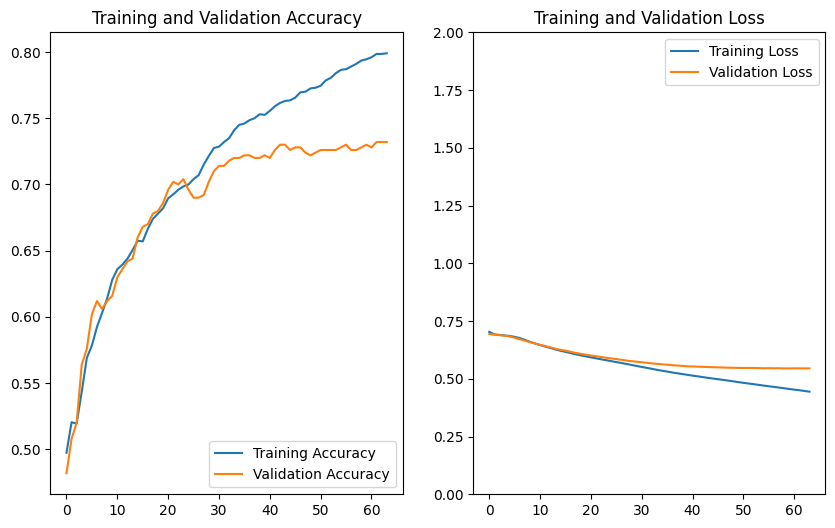

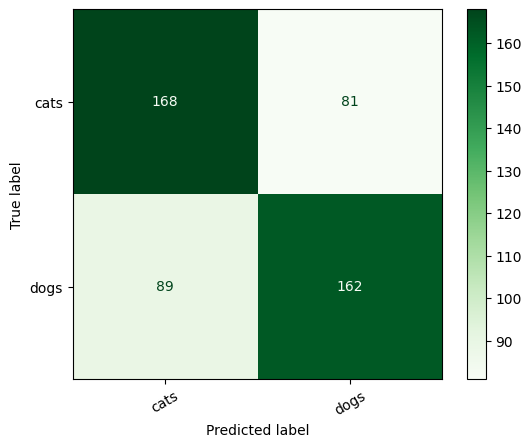

In [59]:
# obter as predições e ground thruth num formato mais fácil de tratar
# (vetores com os ids das classes)

y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# Make predictions
output_pred = cat_or_dog_model.predict(test_ds)
y_pred = (output_pred > 0.5).astype(int).flatten()  # Convert sigmoid output to 0 or 1

# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

n_misses = np.count_nonzero(y_pred != y_true.flatten())
n_preds = y_pred.shape[0]
accuracy = (n_preds - n_misses) / n_preds

print(
    "Falhou em {:d} amostras num total de {:d} imagens de flores".format(
        n_misses, n_preds
    )
)

# Calculate precision, recall, and F1 score
test_precision = precision_score(y_true, y_pred)
test_recall = recall_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred)

print(f"Test Dataset Metrics:")
print("Taxa de acertos: {:.2f} %".format(accuracy * 100))
print(f"Precisão: {test_precision * 100:.4f} %")
print(f"Cobertura: {test_recall * 100:.4f} %")
print(f"F1 Score: {test_f1 * 100:.4f} %")


# gerar gráficos e matriz de confusão
cm = confusion_matrix(y_true, y_pred)

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(len(acc))

# evolucao da loss e acertos
plt.figure(2, figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylim(0, 2)
plt.title("Training and Validation Loss")

# matriz de confusao
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
disp.plot(cmap="Greens", xticks_rotation=30)
plt.show()

## Misclassified images

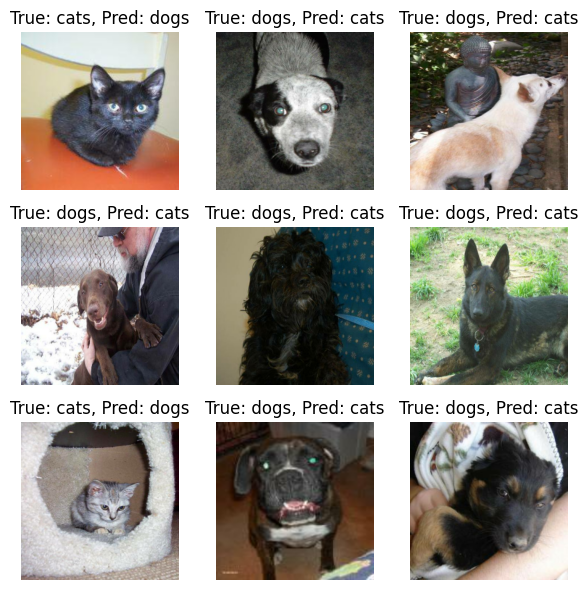

In [60]:
# Collect misclassified images and their labels
misclassified_images = []
misclassified_labels = []
misclassified_predictions = []

for images, labels in test_ds.unbatch():
    predictions = cat_or_dog_model.predict(np.expand_dims(images, axis=0), verbose=0)
    predicted_label = int(predictions[0, 0] > 0.5)
    true_label = int(labels.numpy().item())

    if predicted_label != true_label:
        misclassified_images.append(images.numpy().astype("uint8"))
        misclassified_labels.append(true_label)
        misclassified_predictions.append(predicted_label)

plt.figure(figsize=(6, 6))
for i in range(len(misclassified_images[:9])):
    plt.subplot(3, 3, i + 1)
    plt.imshow(misclassified_images[i])
    plt.title(f"True: {LABELS[misclassified_labels[i]]}, Pred: {LABELS[misclassified_predictions[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

## Prediction on external images

In [61]:
# Load custom dataset
CUSTOM_DATASET_PATH = "../custom_dataset"

custom_ds = utils.image_dataset_from_directory(
    CUSTOM_DATASET_PATH,
    labels="inferred",
    label_mode="binary",
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=1,  # Load one image at a time for display
)

Found 9 files belonging to 2 classes.


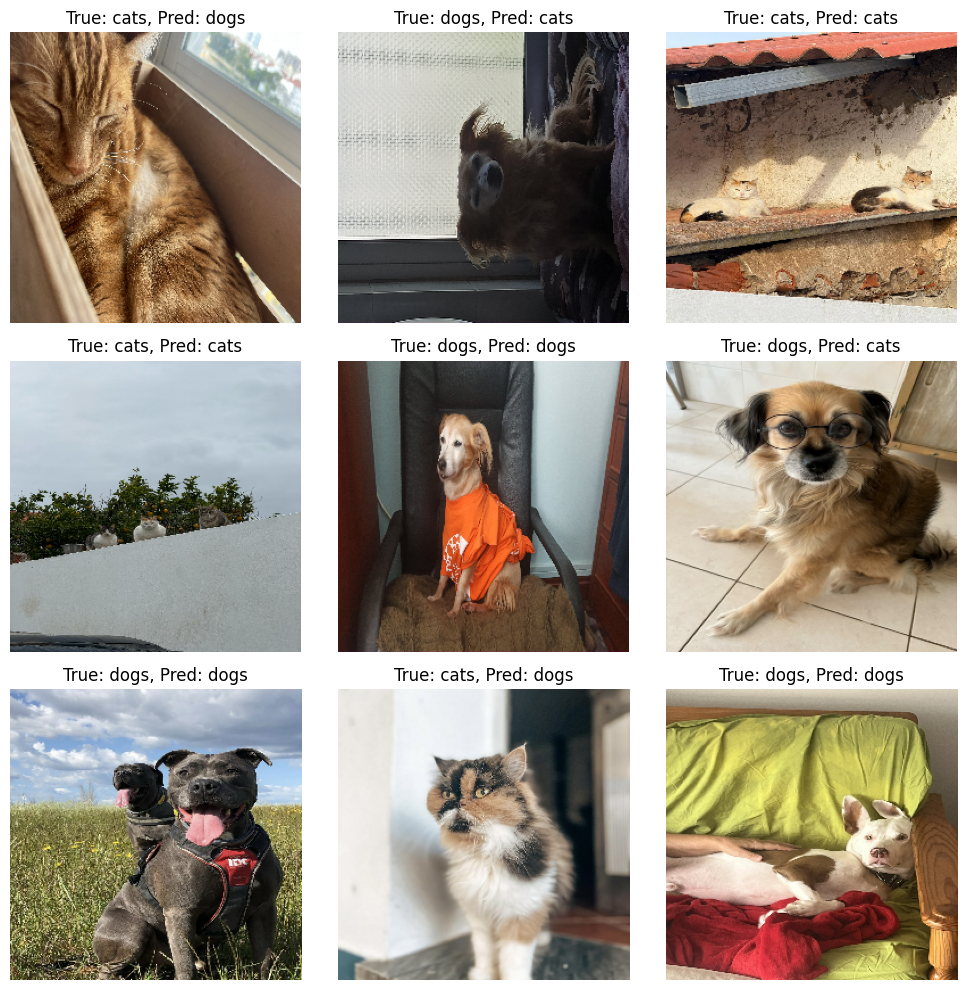

In [62]:
plt.figure(figsize=(10, 10))
for i, (images, labels) in enumerate(custom_ds.unbatch()):
    predictions = cat_or_dog_model.predict(tf.expand_dims(images, axis=0), verbose=0)
    predicted_label = int(predictions[0, 0] > 0.5)
    true_label = int(labels.numpy().item())

    plt.subplot(3, 3, i + 1)
    plt.imshow(images.numpy().astype("uint8"))
    plt.title(f"True: {LABELS[true_label]}, Pred: {LABELS[predicted_label]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


### Prediction quality

In [63]:
# Collect true labels and predictions for the custom dataset
custom_y_true = []
custom_y_pred = []

for images, labels in custom_ds.unbatch():
    predictions = cat_or_dog_model.predict(tf.expand_dims(images, axis=0), verbose=0)
    predicted_label = int(predictions[0, 0] > 0.5)
    true_label = int(labels.numpy().item())

    custom_y_true.append(true_label)
    custom_y_pred.append(predicted_label)

# Calculate metrics
custom_accuracy = accuracy_score(custom_y_true, custom_y_pred)
custom_precision = precision_score(custom_y_true, custom_y_pred)
custom_recall = recall_score(custom_y_true, custom_y_pred)
custom_f1 = f1_score(custom_y_true, custom_y_pred)

print(f"Custom Dataset Metrics:")
print(f"Accuracy: {custom_accuracy * 100:.4f} %")
print(f"Precision: {custom_precision * 100:.4f} %")
print(f"Recall: {custom_recall * 100:.4f} %")
print(f"F1 Score: {custom_f1 * 100:.4f} %")

Custom Dataset Metrics:
Accuracy: 55.5556 %
Precision: 60.0000 %
Recall: 60.0000 %
F1 Score: 60.0000 %
